In [33]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch 
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler
from audioldm.pipeline import duration_to_latent_t_size

from utils.utils import *
sr = 16000

#test


In [34]:
model = build_model(model_name="audioldm-m-full")

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

modelmem = torch.cuda.memory_allocated() / (1024 * 1024) 

print(f"{modelmem} MiB")
print(torch.cuda.memory_summary())


Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8750.4462890625 MiB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   8750 MiB |   8750 MiB |  93974 GiB |  93966 GiB |
|       from large pool |   8495 MiB |   8495 MiB |  90213 GiB |  90204 GiB |
|       from small pool |    254 MiB |    254 MiB |   3761 GiB |   3761 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   8750 MiB |   8750 MiB |  93974 GiB |  93966 GiB |
|       from large pool |   8495 MiB |   849

In [ ]:
prompt = "A grand orchestral arrangement with thunderous percussion, epic brass fanfares, and soaring strings, creating a cinematic atmosphere fit for a heroic battle."
duration = 30.0 


In [36]:
model.cond_stage_model.embed_mode = "text"
text_list = [prompt] 

text_emb = model.get_learned_conditioning(text_list)

unconditional_text = [""] 
unconditional_embedding = model.get_learned_conditioning(unconditional_text)


# End-to-End Text-to-Sound Pipeline

This notebook implements a **MultiDiffusion** extension of DDIM to generate long-form audio from text:

1. **Text → Embedding**: Convert prompt to conditioning vectors via CLAP.
2. **Latent Noise Initialization**: Sample `z` of shape `[1, C, T, F]`.
3. **Scheduler Setup (DDIM)**: Call `sampler.make_schedule()` for timesteps.
4. **MultiDiffusion Chunking** (75% overlap): Split latent along time into overlapping chunks.
5. **Per-Chunk U-Net**: Run model to predict noise for each padded chunk (with CFG).
6. **Overlap-Average**: Merge chunk noise predictions into one full tensor.
7. **Single-Tensor DDIM Step**: Apply DDIM reverse-diffusion math to full tensor.
8. **Repeat** for all timesteps → final latent `x_0`.
9. **VAE Decode**: `x_0` → mel-spectrogram via VAE.
10. **Vocoder**: Convert mel to waveform audio for playback.

---


DEBUG DURATION CONVERSION:
Requested duration: 90.0s
Latent size (time frames): 2304
Latent shape: [1, 8, 2304, 16]
Expected frames per second in latent space: 25.60
DEBUG: total_frames=2304, chunk_size=256, overlap_frames=192, advance_step=64
DEBUG: chunk 1: (0, 256) - frames: 256
DEBUG: chunk 2: (64, 320) - frames: 256
DEBUG: chunk 3: (128, 384) - frames: 256
DEBUG: chunk 4: (192, 448) - frames: 256
DEBUG: chunk 5: (256, 512) - frames: 256
DEBUG: chunk 6: (320, 576) - frames: 256
DEBUG: chunk 7: (384, 640) - frames: 256
DEBUG: chunk 8: (448, 704) - frames: 256
DEBUG: chunk 9: (512, 768) - frames: 256
DEBUG: chunk 10: (576, 832) - frames: 256
DEBUG: chunk 11: (640, 896) - frames: 256
DEBUG: chunk 12: (704, 960) - frames: 256
DEBUG: chunk 13: (768, 1024) - frames: 256
DEBUG: chunk 14: (832, 1088) - frames: 256
DEBUG: chunk 15: (896, 1152) - frames: 256
DEBUG: chunk 16: (960, 1216) - frames: 256
DEBUG: chunk 17: (1024, 1280) - frames: 256
DEBUG: chunk 18: (1088, 1344) - frames: 256
DEBU

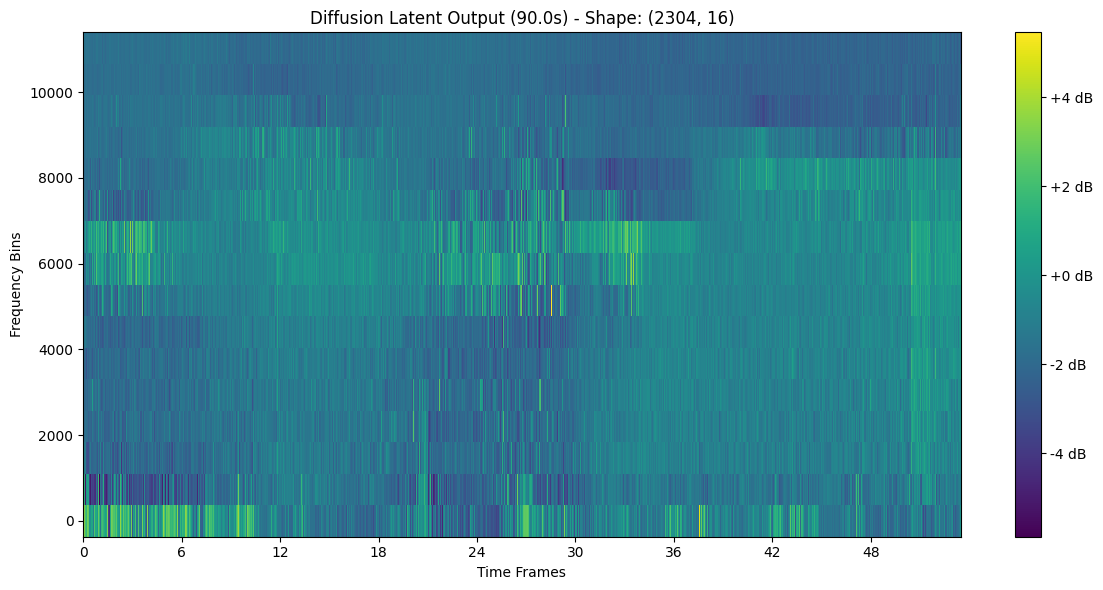

Latent stats - Min: -5.879, Max: 5.453, Mean: -1.224, Std: 0.979


In [37]:
# Run MultiDiffusion Diffusion Loop
## Set parameters
ddim_steps = 200
ddim_eta = 0.1
unconditional_guidance_scale = 3.0
chunk_frames = 256
overlap_frames = int(chunk_frames * 0.75)

# Scheduler and initial noise
sampler = DDIMSampler(model)
latent_size = duration_to_latent_t_size(duration)
shape = [1, model.channels, latent_size, model.latent_f_size]
z = torch.randn(shape).to(model.device)

# Debug duration conversion
print(f"DEBUG DURATION CONVERSION:")
print(f"Requested duration: {duration}s")
print(f"Latent size (time frames): {latent_size}")
print(f"Latent shape: {shape}")
print(f"Expected frames per second in latent space: {latent_size / duration:.2f}")

# Memory & timing
memory_before_diffusion = torch.cuda.memory_allocated() / (1024*1024)
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

with torch.no_grad():
    samples = multidiffusion_sample_clean(
        sampler=sampler,
        shape=shape,
        conditioning=text_emb,
        unconditional_conditioning=unconditional_embedding,
        unconditional_guidance_scale=unconditional_guidance_scale,
        eta=ddim_eta,
        x_T=z,
        S=ddim_steps,
        chunk_frames=chunk_frames,
        overlap_frames=overlap_frames
    )
torch.cuda.synchronize()

# Report performance
diffusion_time = time.time() - start_time
peak_mem = torch.cuda.max_memory_allocated() / (1024*1024)
curr_mem = torch.cuda.memory_allocated() / (1024*1024)
print(f"Diffusion time: {diffusion_time:.2f}s, peak mem: {peak_mem:.1f} MiB, curr mem: {curr_mem:.1f} MiB")

# Display final latent
print(f"Final latent shape: {samples.shape}")
check_for_nan_inf(samples, "Diffusion latent output")
plot_latent_spectrogram(samples, f"Diffusion Latent Output ({duration}s)")

VAE DECODER ISOLATED PEAK: 15113.9 MiB (cost: +10730.5 MiB)
VAE DECODER CURRENT MEMORY: 4383.5 MiB
VAE TIME: 0.7s

🔍 VAE DECODER OUTPUT ANALYSIS:
Mel spectrogram shape: torch.Size([1, 1, 9216, 64])
Latent → Mel conversion factor: 4.00x
Mel frames: 9216
Expected mel duration: 147.46s
✅ VAE mel spectrogram output is clean (no NaN/Inf)

📊 MEL SPECTROGRAM (from VAE Decoder):
DEBUG: mel_tensor.shape = torch.Size([1, 1, 9216, 64]), spec.shape = (9216, 64)


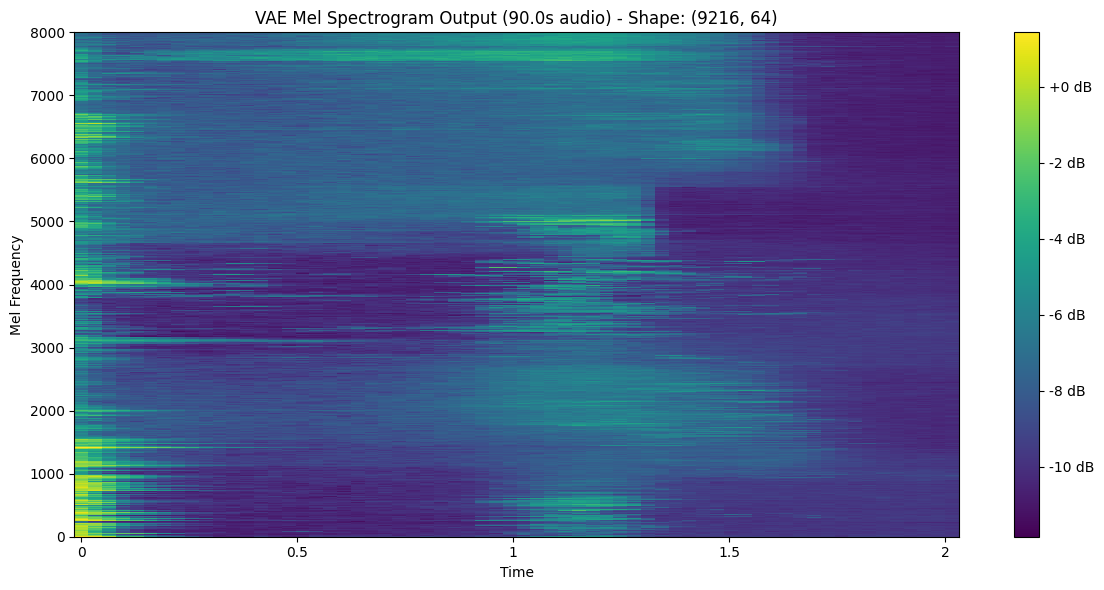

Mel stats - Min: -11.846, Max: 1.426, Mean: -8.401, Std: 1.769
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4383 MiB |  15113 MiB | 134967 GiB | 134962 GiB |
|       from large pool |   4256 MiB |  14986 MiB | 129576 GiB | 129572 GiB |
|       from small pool |    127 MiB |    128 MiB |   5390 GiB |   5390 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   4383 MiB |  15113 MiB | 134967 GiB | 134962 GiB |
|

In [38]:
# VAE DECODER - Using standard approach for now (will optimize later)
# Get memory before VAE and reset peak tracker
memory_before_vae = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run VAE
start_time = time.time()
with torch.no_grad(): 
    mel_spectrogram = model.decode_first_stage(samples)
torch.cuda.synchronize()
vae_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vae

print(f"VAE DECODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VAE DECODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VAE TIME: {vae_time:.1f}s")

# 🔍 VAE DECODER OUTPUT ANALYSIS & VISUALIZATION
print(f"\n🔍 VAE DECODER OUTPUT ANALYSIS:")
print(f"Mel spectrogram shape: {mel_spectrogram.shape}")
print(f"Latent → Mel conversion factor: {mel_spectrogram.shape[2] / samples.shape[2]:.2f}x")
print(f"Mel frames: {mel_spectrogram.shape[2]}")
print(f"Expected mel duration: {mel_spectrogram.shape[2] / 62.5:.2f}s")  # Typical AudioLDM mel rate
check_for_nan_inf(mel_spectrogram, "VAE mel spectrogram output")

# Display mel spectrogram
print(f"\n📊 MEL SPECTROGRAM (from VAE Decoder):")
plot_mel_spectrogram(mel_spectrogram, f"VAE Mel Spectrogram Output ({duration}s audio)", sr=sr)

print(torch.cuda.memory_summary())


In [39]:
# VOCODER - Using standard approach for now (will optimize later)
memory_before_vocoder = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

start_time = time.time()
with torch.no_grad(): 
    waveform = model.mel_spectrogram_to_waveform(mel_spectrogram)[0]
torch.cuda.synchronize()
vocoder_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vocoder

print(f"VOCODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VOCODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VOCODER TIME: {vocoder_time:.1f}s")

print(f"\nFINAL RESULTS:")
print(f"Generated {duration}s audio with MultiDiffusion")
print(f"Audio shape: {waveform.shape}")
print(f"Audio duration (samples): {len(waveform) / sr:.1f}s")
print(f"Expected samples for {duration}s: {int(duration * sr)}")
print(f"Actual samples: {len(waveform)}")
print(f"Duration discrepancy: {(len(waveform) / sr) - duration:.3f}s")
print(f"Mel → Audio conversion factor: {len(waveform) / mel_spectrogram.shape[2]:.1f}x")
print(f"Overall latent → audio factor: {len(waveform) / samples.shape[2]:.1f}x")

ipd.display(ipd.Audio(waveform, rate=sr))
print(torch.cuda.memory_summary())


VOCODER ISOLATED PEAK: 5466.2 MiB (cost: +1082.8 MiB)
VOCODER CURRENT MEMORY: 4383.5 MiB
VOCODER TIME: 0.6s

FINAL RESULTS:
Generated 90.0s audio with MultiDiffusion
Audio shape: (1, 1474592)
Audio duration (samples): 0.0s
Expected samples for 90.0s: 1440000
Actual samples: 1
Duration discrepancy: -90.000s
Mel → Audio conversion factor: 0.0x
Overall latent → audio factor: 0.0x


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4383 MiB |   5466 MiB | 135017 GiB | 135013 GiB |
|       from large pool |   4256 MiB |   5338 MiB | 129627 GiB | 129623 GiB |
|       from small pool |    127 MiB |    127 MiB |   5390 GiB |   5390 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   4383 MiB |   5466 MiB | 135017 GiB | 135013 GiB |
|       from large pool |   4256 MiB |   5338 MiB | 129627 GiB |

In [40]:
# MultiDiffusion implementation complete!
# Next steps: Implement Tiled VAE and then vocoder chunking
